# Johan Hedenström
Exploration

In [1]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import math
import numpy as np
import matplotlib.colors as mc
import matplotlib.pyplot as plt
from copy import deepcopy
from utils import lists
from filter import filter

In [2]:
FILE_PATH = '../data/tof_erda/raw/I_36MeV_SH2-1_TiN-ref.lst' #'../data/tof_erda/raw/I_36MeV_SH2-12_S18.lst'
chn = [2048,2048]
header, events, timing = lists.lstRead(FILE_PATH)

In [3]:
coin = [True, True, False, False, False, False, False, False]
zdrop = True
outLists = lists.getCoins(events,coin,zdrop)

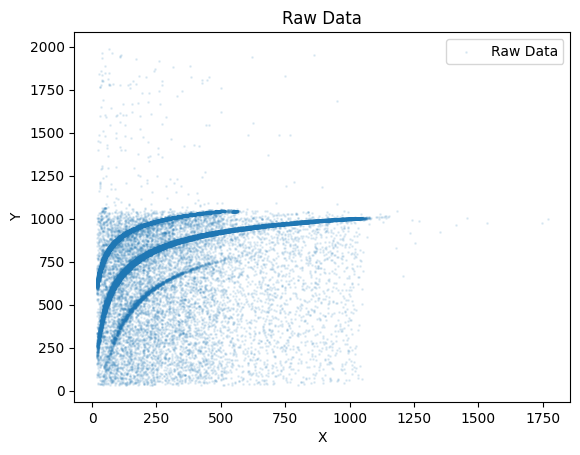

In [4]:
X = np.array(outLists[0])
Y = np.array(outLists[1])

plt.scatter(X, Y, s=1, alpha=0.1, label='Raw Data')
plt.title("Raw Data")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()

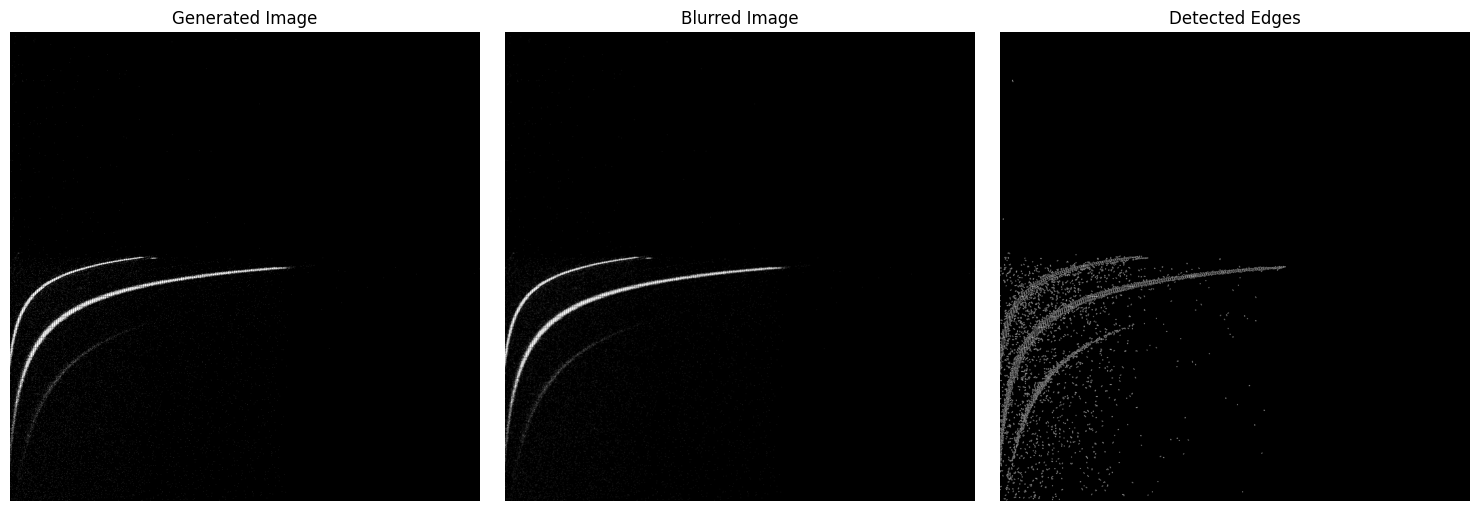

In [5]:
import numpy as np
import cv2
from scipy.interpolate import splprep, splev
from scipy.spatial import KDTree
import matplotlib.pyplot as plt
from matplotlib.path import Path

# Convert raw data to image
img_size = (2000, 2000)
img = np.zeros(img_size, dtype=np.uint8)
x_norm = ((X - X.min()) / (X.max() - X.min()) * (img_size[1] - 1)).astype(int)
y_norm = (img_size[0] - 1 - ((Y - Y.min()) / (Y.max() - Y.min()) * (img_size[0] - 1))).astype(int)
for x, y in zip(x_norm, y_norm):
    img[y, x] = 255

# Smooth image to reduce noise
blurred_img = cv2.GaussianBlur(img, (5, 5), 0)

# Canny Edge Detection to detect trajectories
edges = cv2.Canny(blurred_img, 50, 150)

plt.figure(figsize=(15, 5))

# Original Image
plt.subplot(1, 3, 1)
plt.title("Generated Image")
plt.imshow(img, cmap='gray')
plt.axis('off')

# Blurred Image
plt.subplot(1, 3, 2)
plt.title("Blurred Image")
plt.imshow(blurred_img, cmap='gray')
plt.axis('off')

# Detected edges
plt.subplot(1, 3, 3)
plt.title("Detected Edges")
plt.imshow(edges, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

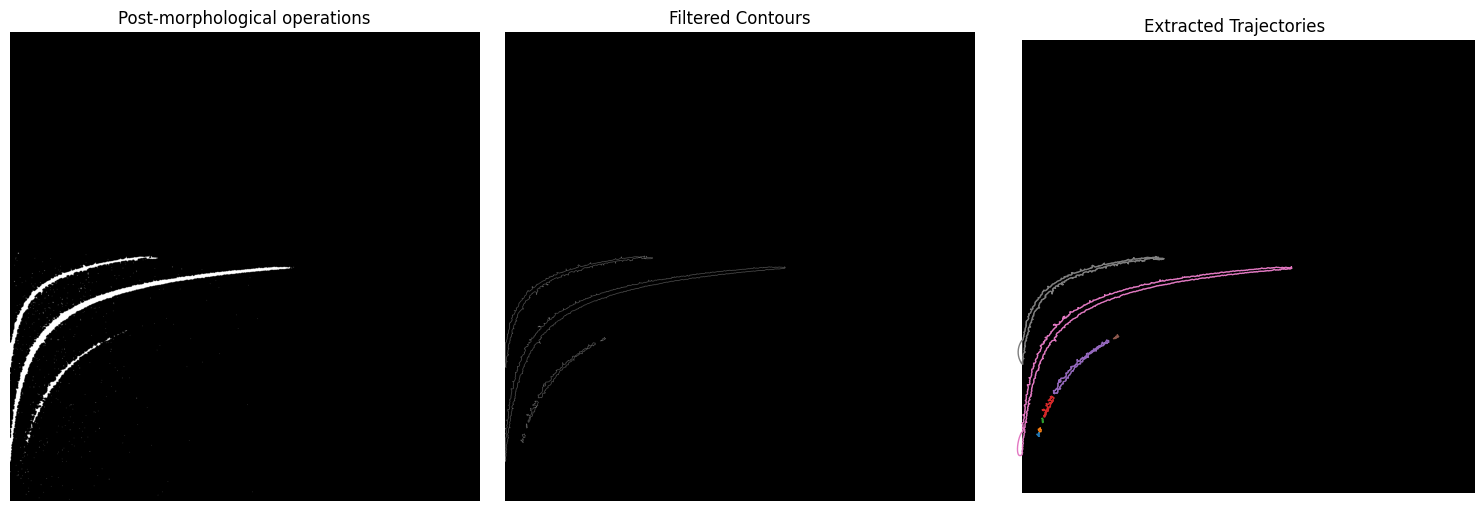

In [11]:
# Angle between two vectors
def angle_between_vectors(v1, v2):
    v1 = v1 / np.linalg.norm(v1)
    v2 = v2 / np.linalg.norm(v2)
    return np.degrees(np.arccos(np.clip(np.dot(v1, v2), -1.0, 1.0)))

# Merge contours by proximity and direction
def connect_contours(contours, tree, endpoints, contour_map, max_dist=25, max_angle=30):
    connected_contours = []
    used_contours = set()

    for i, contour in enumerate(contours):
        if i in used_contours:
            continue

        merged_points = [contour[:, 0, :]]
        used_contours.add(i)

        for point_type in ["start", "end"]:
            endpoint = contour[0, 0] if point_type == "start" else contour[-1, 0]
            direction = contour[1, 0] - endpoint if point_type == "start" else endpoint - contour[-2, 0]

            # Find nearest endpoint
            dist, idx = tree.query(endpoint)
            if dist < max_dist:
                neighbor_index, neighbor_type = contour_map[idx]

                if neighbor_index not in used_contours:
                    # Compare directions
                    neighbor = contours[neighbor_index]
                    neighbor_endpoint = neighbor[0, 0] if neighbor_type == "start" else neighbor[-1, 0]
                    neighbor_direction = neighbor[1, 0] - neighbor_endpoint if neighbor_type == "start" else neighbor_endpoint - neighbor[-2, 0]

                    angle = angle_between_vectors(direction, neighbor_direction)
                    if angle < max_angle:
                        if neighbor_type == "start":
                            merged_points.append(neighbor[:, 0, :])
                        else:
                            merged_points.append(neighbor[::-1, 0, :])
                        used_contours.add(neighbor_index)

        # Merge all points and append to the result
        connected_contours.append(np.vstack(merged_points))

    return connected_contours

# Extract start and end points of contours
def extract_endpoints(contours):
    endpoints = []
    contour_map = []
    for i, contour in enumerate(contours):
        start_point = contour[0, 0]
        end_point = contour[-1, 0]
        endpoints.append(start_point)
        endpoints.append(end_point)
        contour_map.append((i, "start"))
        contour_map.append((i, "end"))

    return np.array(endpoints), contour_map

# Morhpological operations to denoise and enhance trajectories
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9, 9))
cleaned_img = cv2.morphologyEx(blurred_img, cv2.MORPH_CLOSE, kernel)
_, cleaned_img = cv2.threshold(cleaned_img, 50, 255, cv2.THRESH_BINARY)

# Detect contours and filter out potential noise
contours, _ = cv2.findContours(cleaned_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
min_contour_length = 40
filtered_contours = [
    contour for contour in contours if cv2.arcLength(contour, closed=False) > min_contour_length
]

# Extract endpoints and build k-d tree (for performance)
endpoints, contour_map = extract_endpoints(filtered_contours)
tree = KDTree(endpoints)

# Connect contours
connected_contours = connect_contours(
    filtered_contours, tree, endpoints, contour_map, max_dist=25, max_angle=30
)

# Fit smooth curves to connected contours
trajectories = []
for points in connected_contours:
    if len(points) > 10:
        x, y = points[:, 0], points[:, 1]
        tck, _ = splprep([x, y], s=5)
        smooth_x, smooth_y = splev(np.linspace(0, 1, 1000), tck)
        trajectories.append((smooth_x, smooth_y))


plt.figure(figsize=(15, 5))

# After morph
plt.subplot(1, 3, 1)
plt.title("Post-morphological operations")
plt.imshow(cleaned_img, cmap='gray')
plt.axis('off')

# Contours
contour_img = np.zeros_like(cleaned_img)
cv2.drawContours(contour_img, filtered_contours, -1, (255, 255, 255), 1)
plt.subplot(1, 3, 2)
plt.title("Filtered Contours")
plt.imshow(contour_img, cmap='gray')
plt.axis('off')

# Trajectories
plt.subplot(1, 3, 3)
plt.title("Extracted Trajectories")
plt.imshow(contour_img, cmap='gray')
for smooth_x, smooth_y in trajectories:
    plt.plot(smooth_x, smooth_y, linewidth=1)
plt.axis('off')

plt.tight_layout()
plt.show()


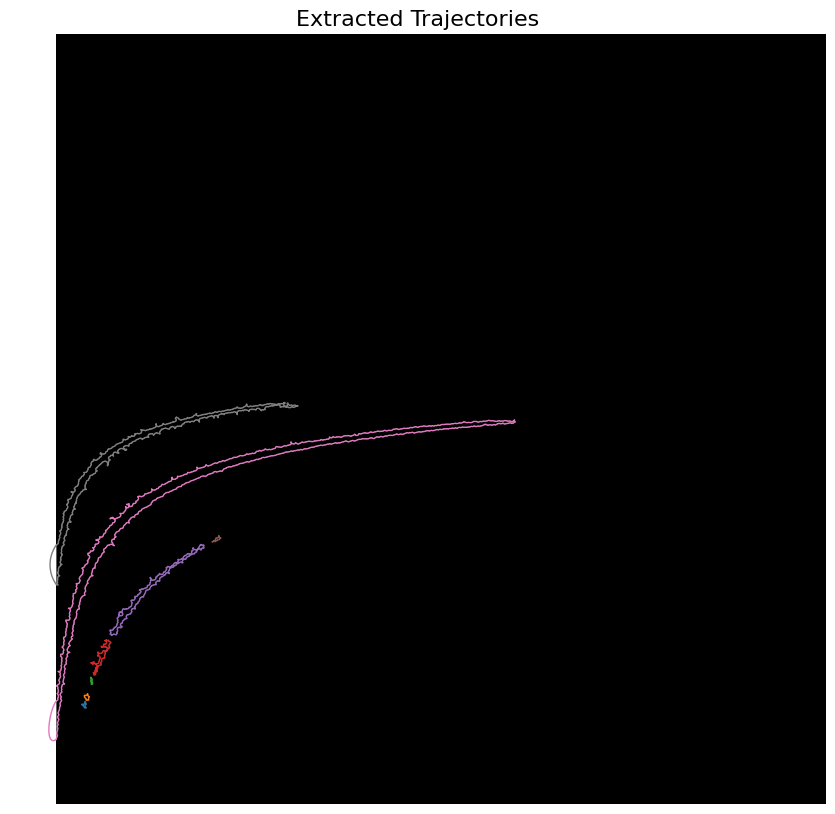

In [12]:
plt.figure(figsize=(20, 10))
plt.title("Extracted Trajectories", fontsize=16)
plt.imshow(contour_img, cmap='gray')
for smooth_x, smooth_y in trajectories:
    plt.plot(smooth_x, smooth_y, linewidth=1)
plt.axis('off')
plt.show()


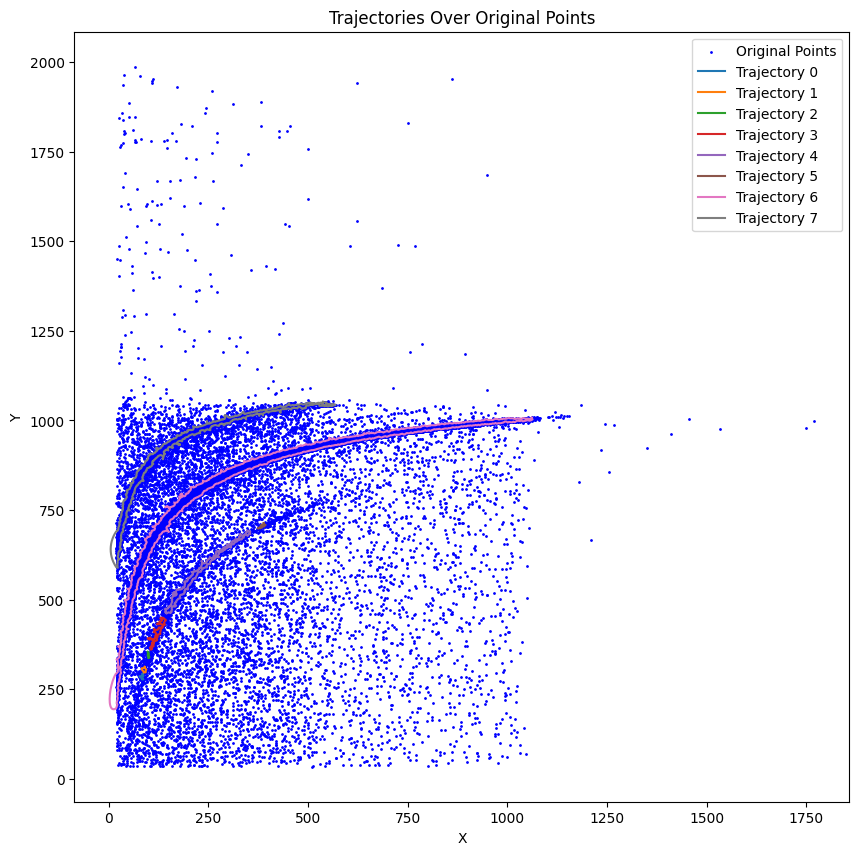

In [13]:
plt.figure(figsize=(10, 10))

plt.scatter(X, Y, color='blue', s=1)
for i, (smooth_x, smooth_y) in enumerate(trajectories):
    # Transform back to original coordinate system
    trajectory_x = smooth_x * (X.max() - X.min()) / (img_size[1] - 1) + X.min()
    trajectory_y = ((img_size[0] - 1) - smooth_y) * (Y.max() - Y.min()) / (img_size[0] - 1) + Y.min()
    
    plt.plot(trajectory_x, trajectory_y, label=f'Trajectory {i}')

plt.title("Trajectories Over Original Points")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()


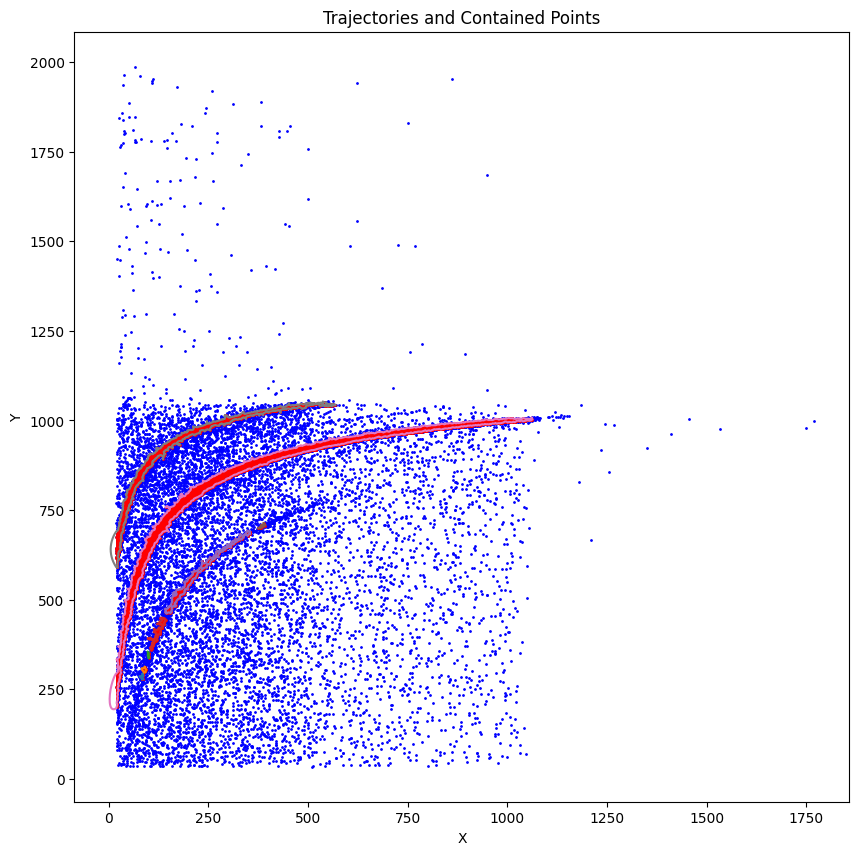

In [15]:
plt.figure(figsize=(10, 10))
plt.scatter(X, Y, color='blue', s=1)

# Find points contained within trajectories
inside_points_mask = np.zeros(len(X), dtype=bool)
for i, (smooth_x, smooth_y) in enumerate(trajectories):
    # Convert trajectory back to the original space
    trajectory_x = smooth_x * (X.max() - X.min()) / (img_size[1] - 1) + X.min()
    trajectory_y = ((img_size[0] - 1) - smooth_y) * (Y.max() - Y.min()) / (img_size[0] - 1) + Y.min()
    
    # Create a closed polygon path from the trajectory
    trajectory_path = Path(np.column_stack((trajectory_x, trajectory_y)))

    # Extract contained points
    points = np.column_stack((X, Y))
    inside_trajectory = trajectory_path.contains_points(points)
    inside_points_mask |= inside_trajectory
    
    #plt.plot(trajectory_x, trajectory_y)

filtered_X = X[inside_points_mask]
filtered_Y = Y[inside_points_mask]
plt.scatter(filtered_X, filtered_Y, color='red', s=1)

plt.title("Trajectories and Contained Points")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()


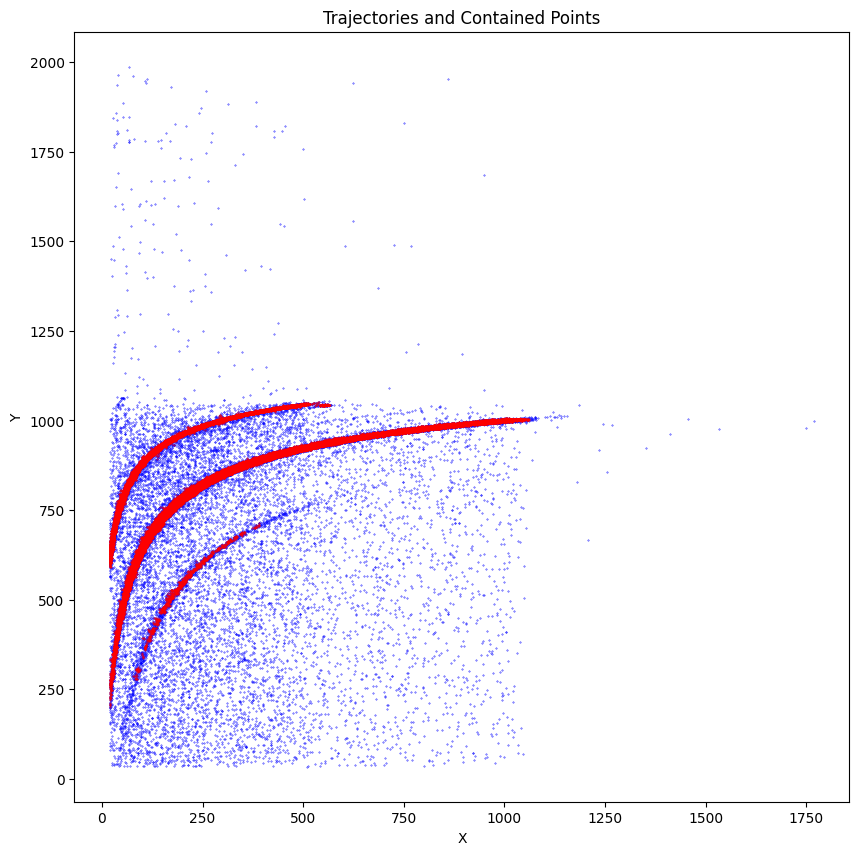

In [17]:
plt.figure(figsize=(10, 10))
plt.scatter(X, Y, color='blue', s=0.1)

# Find points contained within trajectories
inside_points_mask = np.zeros(len(X), dtype=bool)
for i, (smooth_x, smooth_y) in enumerate(trajectories):
    # Convert trajectory back to the original space
    trajectory_x = smooth_x * (X.max() - X.min()) / (img_size[1] - 1) + X.min()
    trajectory_y = ((img_size[0] - 1) - smooth_y) * (Y.max() - Y.min()) / (img_size[0] - 1) + Y.min()
    
    # Create a closed polygon path from the trajectory
    trajectory_path = Path(np.column_stack((trajectory_x, trajectory_y)))

    # Extract contained points
    points = np.column_stack((X, Y))
    inside_trajectory = trajectory_path.contains_points(points)
    inside_points_mask |= inside_trajectory
    
    #plt.plot(trajectory_x, trajectory_y)

filtered_X = X[inside_points_mask]
filtered_Y = Y[inside_points_mask]
plt.scatter(filtered_X, filtered_Y, color='red', s=0.1)

plt.title("Filtered trajectory points")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()
